# How and what affects the review scores of airbnb most; price, hosts, or location?

Sydney Airbnb Data Listing

Karen Stevani (z5573992)

In [2]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import math

In [3]:
%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (30, 15)

In [5]:
saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to

In [6]:
#loading from file
if os.path.isfile("sydney_airbnb_listing.csv"):
    filepath = "sydney_airbnb_listing.csv"
    print("loading from file")
else:
    filepath = "https://data.insideairbnb.com/australia/nsw/sydney/2024-03-16/data/listings.csv.gz"
    print("loading from the internet")

listing_data = pd.read_csv(filepath)
print("done")

loading from file
done


In [7]:
shp_file_name = r"gda2020 (1).zip"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/dowload/"
    "nsw_locality_polygon_shp.zip"
)

In [8]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.zipfile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [9]:
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, "wb") as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


Data Set: "Detailed Sydney Listings data" from insideairbnb.com

Published by: Inside Airbnb, licensed under a Creative Commons Attribution 4.0 International License, on 10 June 2024

With a total of 14274 rows and 75 columns, this dataset explores Sydney's airbnb market that has steadily started from the year of 2009 to current times. It provides information of hosts behaviors (name, id, verification, address, the time they started, response rate, response time, listing count, the license they used, and more), listing informations (price, longitude, latitude, availability, how many person it accommodates, amount of rooms and bathrooms, facilities, property type and more), and various reviews related to it.

Sydney, a place with one of the highest housing market prices right now, is an area that is highly famous with tourism. Because of this, airbnbs play a pivotal role in providing shelter for tourists and sometimes even for longer stays of immigrants or locals in the area. Which is why through this data project, comparisons of price, host, and locations are analyzed to see whether and how much they affect each other. As well as if they correlate to the review scores and should affect your choice in booking an airbnb.

In [10]:
listing_data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1050164598350388320,https://www.airbnb.com/rooms/1050164598350388320,20240316023820,2024-03-18,city scrape,Self service English breakfast,Close to transport airport older style unit ne...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,211218678,...,NaN,NaN,NaN,PID-STRA-61891,f,1,0,1,0,NaN
1,1096082243192434668,https://www.airbnb.com/rooms/1096082243192434668,20240316023820,2024-03-18,city scrape,Apartment in Rushcutters Bay,Full 2 bedroom apartment with balcony. Walking...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,26721338,...,NaN,NaN,NaN,Exempt,f,2,1,1,0,NaN
2,2167538,https://www.airbnb.com/rooms/2167538,20240316023820,2024-03-18,city scrape,"Modern Sydney home near beach,shops",**Availability extremely flexible**<br /><br /...,Queens Park is a safe and friendly neighbourho...,https://a0.muscache.com/pictures/29922910/2399...,11059668,...,5.00,5.00,4.00,NaN,f,1,1,0,0,0.01
3,790607305500629830,https://www.airbnb.com/rooms/790607305500629830,20240316023820,2024-03-18,city scrape,Luxury double room,Relax in this tranquil and stylish space.,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,202112801,...,4.77,4.68,4.68,PID-STRA-21723,f,30,5,25,0,2.13
4,641106357139201992,https://www.airbnb.com/rooms/641106357139201992,20240316023820,2024-03-18,city scrape,Chic Studio Apartment in Prime Bondi Location,Immerse yourself in the vibrant atmosphere of ...,Bondi is one of Australia’s most iconic suburb...,https://a0.muscache.com/pictures/prohost-api/H...,279001183,...,3.94,4.94,4.29,PID-STRA-36651,f,217,217,0,0,0.84


In [11]:
listing_data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

#### 1. Value (Price)

Value that is discussed here is in relation to pricing. As potential customers, we are always looking for reasonable value for our money's worth, especially in Sydney's curent intense housing market state. Although there are also aspects that affects pricing itself, such as the amount of space, facilities, location, hygiene, estate's age and more, this filtration process will mainly focus on standardizing the price for accomodating one person's living and the average price airbnb price for one person as a benchmark.

In [12]:
listing_data.price

0        $100.00
1        $250.00
2        $650.00
3         $84.00
4        $508.00
          ...   
14269     $88.00
14270    $143.00
14271    $120.00
14272    $180.00
14273    $123.00
Name: price, Length: 14274, dtype: object

In [13]:
listing_data.accommodates

0        2
1        4
2        5
3        1
4        2
        ..
14269    2
14270    2
14271    4
14272    2
14273    2
Name: accommodates, Length: 14274, dtype: int64

In [14]:
listing_data['price'] = listing_data['price'].replace({'\$': '', ',': ''}, regex=True)
listing_data['price'] = pd.to_numeric(listing_data['price'], errors='coerce').astype('Int64')  # Use 'Int64' to handle NaN values
listing_data['price'] = listing_data['price'].fillna(0).astype(int)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\karen\AppData\Local\Temp\ipykernel_21604\2283849491.py:1: SyntaxWarning: invalid escape sequence '\$'
  listing_data['price'] = listing_data['price'].replace({'\$': '', ',': ''}, regex=True)


In [15]:
listing_data['standard_price'] = listing_data['price'] / listing_data['accommodates']
listing_data.standard_price

0         50.0
1         62.5
2        130.0
3         84.0
4        254.0
         ...  
14269     44.0
14270     71.5
14271     30.0
14272     90.0
14273     61.5
Name: standard_price, Length: 14274, dtype: float64

In [16]:
average_price = listing_data['price'].mean()
print(f"The average price is: ${average_price}")

average_standard_price = listing_data['standard_price'].mean()
print(f"The average price per person is: ${average_standard_price}")

The average price is: $395.94689645509317
The average price per person is: $95.22062845427966


Through taking data from the price column and corresspondingly, the accommodates column, I am able to manipulate their data types to create a new column that divides the two values together respectively. This allows a more standardized price that will allow a fairer comparison later with other categories. I also extracted the average price to book an airbnb in sydney for future reference, which are roughly $396 for its original non standerdized price and $95 as the average for one airbnb night booking per person.

#### 2. Hosts

Hosts are the landlords of airbnbs. They are the owners of the airbnb property and sometimes lives in the property they are listing. There are many information categories that are provided of the host in this dataset. Some of the more interesting ones include where they are located and the license they used for verification. But for the main exploration of host's correlation to review scores and the other two aspects being questioned, the duration length of them being hosts is the main focused column

In [29]:
listing_data.host_identity_verified.value_counts()

host_identity_verified
t    13605
f      669
Name: count, dtype: int64

<Figure size 500x250 with 0 Axes>

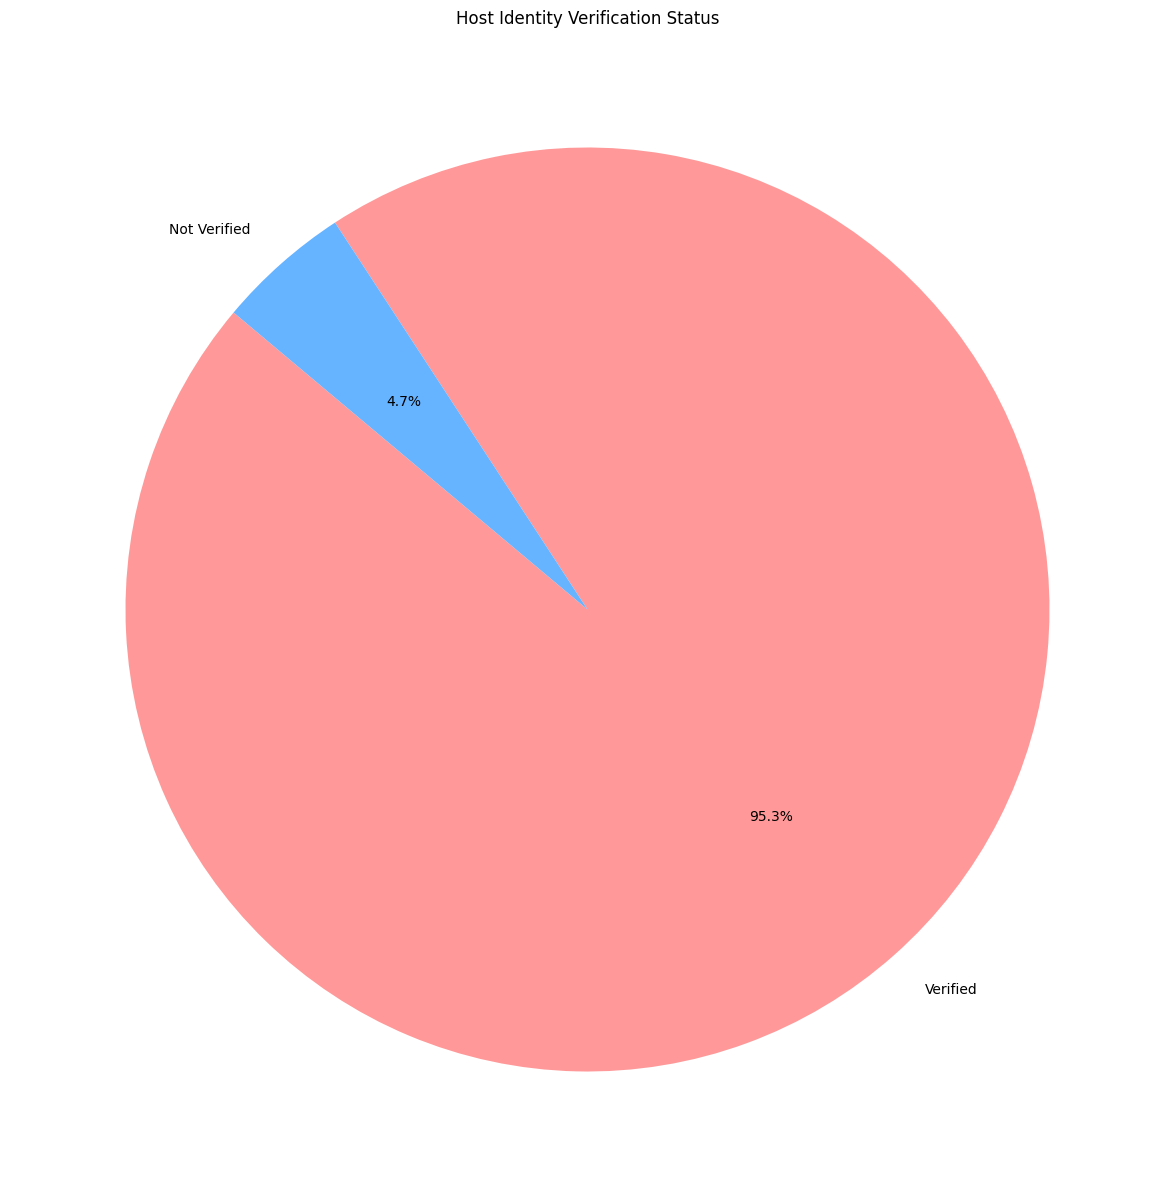

In [37]:
data = {'Status': ['Verified', 'Not Verified'], 'Count': [13605, 669]}
licensepie = pd.DataFrame(data)

plt.figure(figsize=(5, 2.5))
licensepie.set_index('Status').plot.pie(y='Count', autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], legend=False, startangle=140)
plt.title('Host Identity Verification Status')
plt.ylabel('')
plt.show()

As seen from the data, majority of hosts (95.3%) are verified with their status as a host, whereas a minority of 7.4% are not. This will be explored further later if it causes any effect on the airbnb reviews. 

In [53]:
listing_data.host_since

0        2018-08-22
1        2015-01-26
2        2014-01-06
3        2018-07-13
4        2019-07-24
            ...    
14269    2015-02-23
14270    2015-12-21
14271    2022-07-03
14272    2023-10-07
14273    2017-10-08
Name: host_since, Length: 14274, dtype: object

In [54]:
listing_data['host_since'] = pd.to_datetime(listing_data['host_since'])
date_format_pattern = "%B, %Y"
earliest_date = datetime.strftime(listing_data.host_since.min(), date_format_pattern)
latest_date = datetime.strftime(listing_data.host_since.max(), date_format_pattern)
f"The range of someone becoming an airbnb host in Sydney is {earliest_date} to {latest_date}"

'The range of someone becoming an airbnb host in Sydney is June, 2009 to March, 2024'

In [56]:
listing_data['host_since'] = pd.to_datetime(listing_data['host_since'])
reference_date = pd.Timestamp('2024-08-01')
listing_data['days_since_start'] = (reference_date - listing_data['host_since']).dt.days
listing_data.days_since_start

0        2171
1        3475
2        3860
3        2211
4        1835
         ... 
14269    3447
14270    3146
14271     760
14272     299
14273    2489
Name: days_since_start, Length: 14274, dtype: int64

In [57]:
average_age_as_host = listing_data['days_since_start'].mean()
print(f"The average age someone has become an airbnb host in Sydney is {average_age_as_host} days")

The average age someone has become an airbnb host in Sydney is 2615.159030404932 days


After calculations, the average duration someone has become an airbnb host in Sydney is 2622.159030404932 days or roughly about 7 years, 2 months, and 5 days. Meaning most airbnb hosts, started listing around 2017. With the new column calculated of how long (in terms of days) each person has become an airbnb host in Sydney, this allows comparison graph of the host compared to the other aspects issued and the main review scores